![seQuencing logo](../images/sequencing-logo.svg)

# Controlling a `Transmon` coupled to a `Cavity`

In this tutorial, we will start to write some serious sequences, starting with [basic calibration](#Basic-calibration) of single [Modes](../api/classes.rst#Modes), and moving on to explore the fundamental toolkit for [manipulating a dispersively coupled qubit and cavity](#Quantum-control-in-the-dispersive-regime). 

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import inspect
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import qutip

from sequencing import Transmon, Cavity, System, get_sequence, sync, delay
from sequencing.calibration import fit_sine, fit_displacement, tune_rabi, tune_displacement, tune_drag

In [2]:
qubit = Transmon('qubit', levels=2)
qubit.gaussian_pulse.sigma = 5 # ns
qubit.gaussian_pulse.chop = 4 # sigma
system = System('system', modes=[qubit])

## Basic calibration

### Rabi

Let's write an "amplitude Rabi" sequence to tune the amplitude of our qubit's [GaussianPulse](../api/classes.rst#GaussianPulse).

<IPython.core.display.Javascript object>


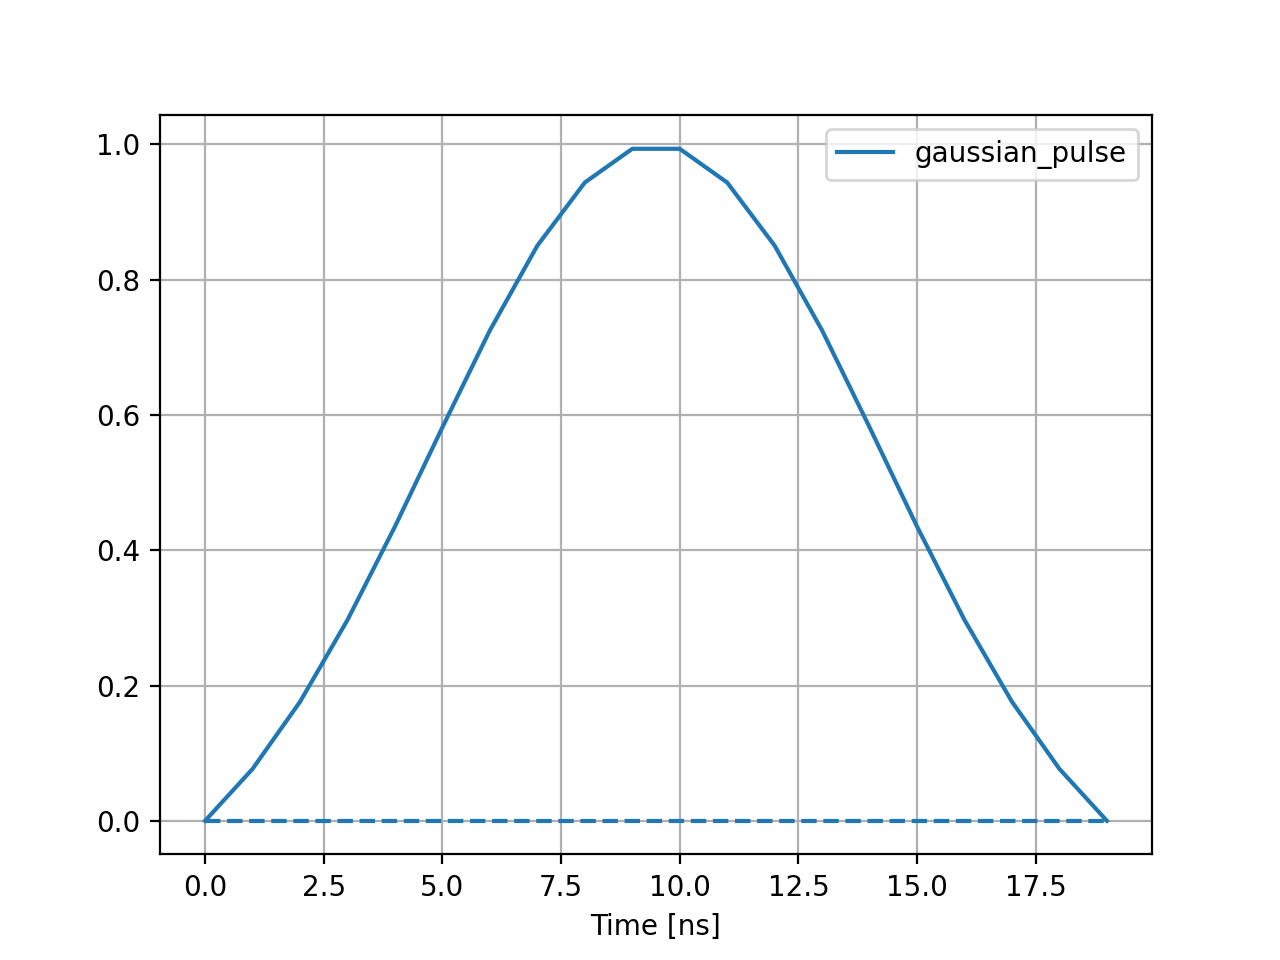

In [3]:
ax = qubit.gaussian_pulse.plot()
_ = ax.set_xlabel('Time [ns]')

In [4]:
pulse_amps = np.linspace(-2, 2, 51)
init_state = qubit.fock(0) # start in |g>
e_ops = [qubit.fock(1)] # measure P(|e>)

In [5]:
e_population = []
for amp in tqdm(pulse_amps, desc='Pulse amp'):
    with qubit.pulse_scale(amp):
        seq = get_sequence(system)
        qubit.rotate_x(np.pi)
        result = seq.run(init_state, e_ops=e_ops)
        e_population.append(result.expect[0][-1])

Pulse amp: 100%|███████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 51.39it/s]


In [6]:
fit_result = fit_sine(pulse_amps, e_population)
optimal_amp = 1 / (2 * fit_result.params['f0'].value)
print('Initial amplitude: 1')
print(f'Optimal scale factor: {optimal_amp:.5f}')

Initial amplitude: 1
Optimal scale factor: 1.05253


In [7]:
qubit.gaussian_pulse.amp = optimal_amp

e_population_final = []
for amp in tqdm(pulse_amps, desc='Pulse amp (after update)'):
    with qubit.pulse_scale(amp):
        seq = get_sequence(system)
        qubit.rotate_x(np.pi)
        result = seq.run(init_state, e_ops=e_ops)
        e_population_final.append(result.expect[0][-1])

Pulse amp (after update): 100%|████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 58.86it/s]


In [8]:
fit_result_final = fit_sine(pulse_amps, e_population_final)
optimal_amp_final = 1 / (2 * fit_result_final.params["f0"].value)
print('Initial amplitude: 1', flush=True)
print(f'Optimal scale factor: {optimal_amp_final:.5f}')

Initial amplitude: 1
Optimal scale factor: 1.00000


<IPython.core.display.Javascript object>


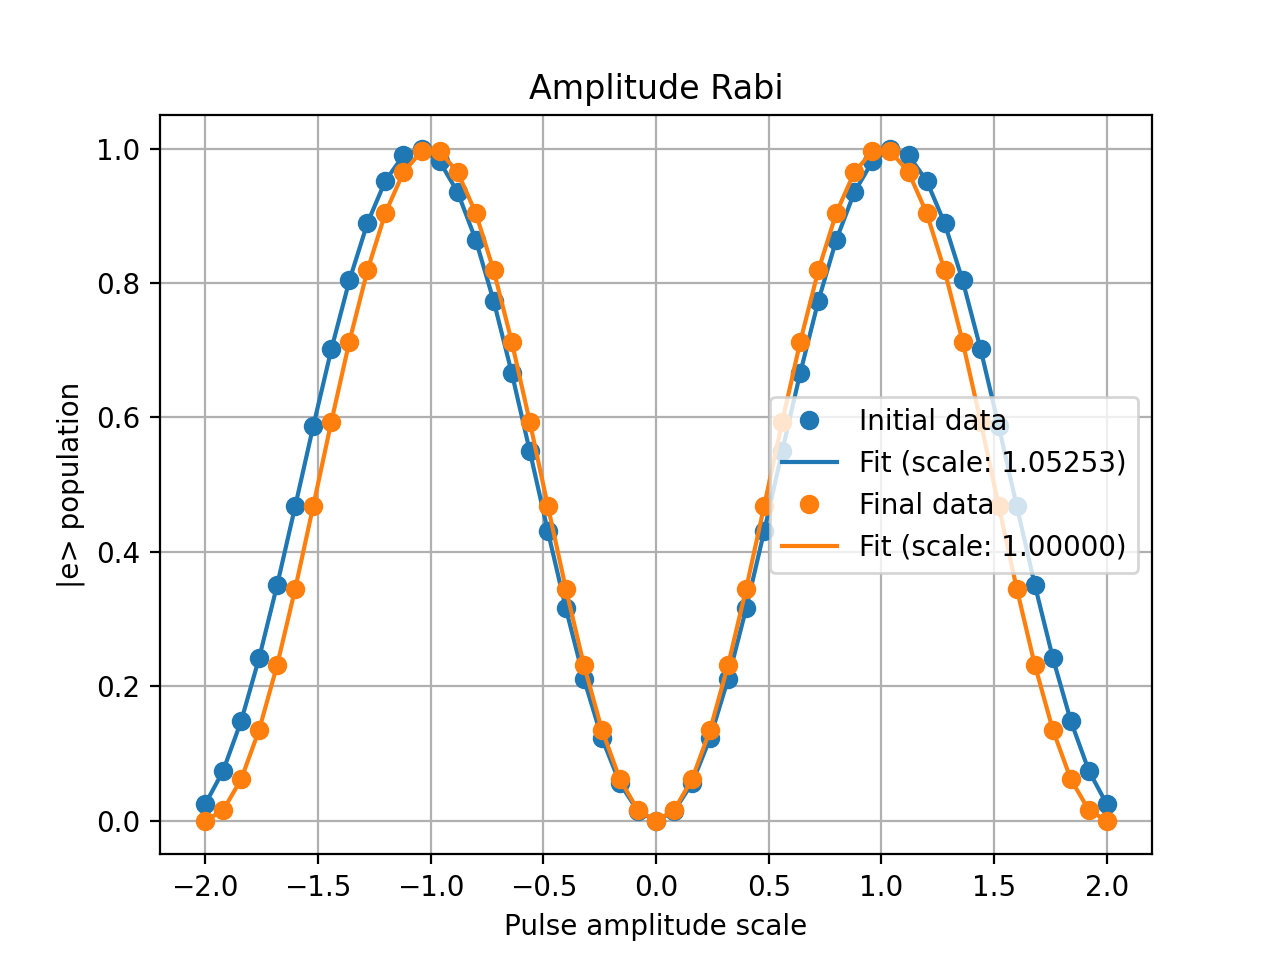

In [9]:
fig, ax = plt.subplots()
ax.plot(
    pulse_amps, e_population, 'C0o', label='Initial data'
)
ax.plot(
    pulse_amps, fit_result.best_fit, 'C0-', label=f'Fit (scale: {optimal_amp:.5f})'
)
ax.plot(
    pulse_amps, e_population_final, 'C1o', label='Final data'
)
ax.plot(
    pulse_amps, fit_result_final.best_fit, 'C1-',
    label=f'Fit (scale: {optimal_amp_final:.5f})'
)
ax.set_xlabel('Pulse amplitude scale')
ax.set_ylabel('|e> population')
ax.set_title('Amplitude Rabi')
ax.grid(True)
_ = ax.legend(loc=0)

Let's check how well we have tuned up our $\pi$-pulse by looking at state fidelities:

In [10]:
seq = get_sequence(system)
qubit.rotate_x(np.pi)
result = seq.run(init_state)

ideal_state = qubit.rotate_x(np.pi, unitary=True) * init_state
fid_g_to_e = qutip.fidelity(result.states[-1], ideal_state)**2
print(f'State fidelity |g> -> |e>: {fid_g_to_e:.5f}')

init_state = qubit.fock(1) # start in |e>
result = seq.run(init_state)
ideal_state = qubit.rotate_x(np.pi, unitary=True) * init_state
fid_e_to_g = qutip.fidelity(result.states[-1], ideal_state)**2
print(f'State fidelity |e> -> |g>: {fid_e_to_g:.5f}')

State fidelity |g> -> |e>: 1.00000
State fidelity |e> -> |g>: 1.00000


This is such a common and useful tuneup sequence that `sequencing.calibration` has a [built-in function](../api/functions.rst#tune-rabi) to handle it:

In [11]:
print('sequencing.calibration.tune_rabi():')
print('\n\t'.join([''] + inspect.getdoc(tune_rabi).splitlines()))

sequencing.calibration.tune_rabi():

	Tune the amplitude of a Transmon pulse using
	an amplitude-Rabi experiment.
	
	Args:
	    system (System): System containing the Transmon whose
	        pulse you want to tune.
	    init_state (qutip.Qobj): Initial state of the system.
	    e_ops (optional, list[qutip.Qobj]): List of expectation
	        operators. If none, defaults to init_state. Default: None.
	    mode_name (optional, str): Name of the Transmon mode. Default: 'qubit'.
	    pulse_name (optional, str): Name of the pulse to tune. If None,
	        will use transmon.default_pulse. Default: None.
	    amp_range (optional, tuple[float, float, int]): Range over which to
	        sweep the pulse amplitude, specified by (start, stop, num_steps).
	        The units are such that, if the pulse is tuned up, amplitude of 1
	        generates a rotation by pi. Default: (-2, 2, 51).
	    progbar (optional, bool): Whether to display a tqdm progress bar.
	        Default: True.
	    plot (option

### DRAG

For weakly anharmonic systems like transmon qubits, the existence of levels above $|g\rangle$ and $|e\rangle$ can lead to errors for fast gates. Here, we demonstrate the use of DRAG (Derivative Removal by Adiabatic Gate) to reduce the magnitude of these errors.

First, we demonstrate the problem by adding a third level to our transmon, and adding an experimentally reasonable anharmonicity of 200 MHz.

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 42.38it/s]


<IPython.core.display.Javascript object>


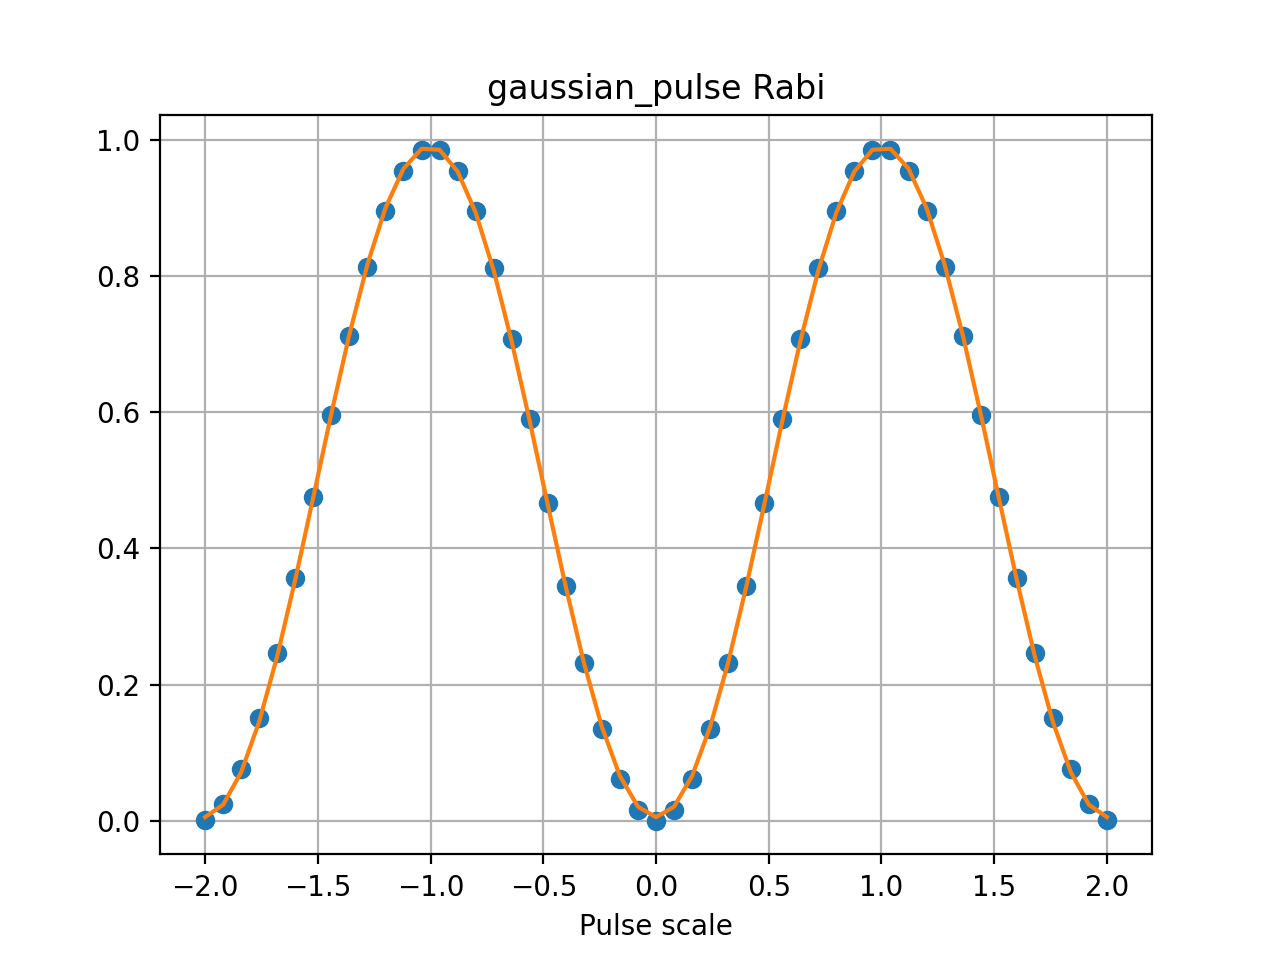

Updating qubit unit amp from 1.05e+00 to 1.06e+00.


In [12]:
qubit.levels = 3
qubit.anharmonicity = -200e-3 # GHz
init_state = qubit.fock(0)
_, old_amp, new_amp = tune_rabi(
    system, init_state, mode_name='qubit',
    e_ops=[qubit.fock(1)], verify=False
)

In [13]:
seq = get_sequence(system)
qubit.rotate_x(np.pi)
result = seq.run(init_state)
ideal_state = qubit.rotate_x(np.pi, unitary=True) * init_state
fid_g_to_e = qutip.fidelity(result.states[-1], ideal_state)**2
print(f'State fidelity |g> -> |e>: {fid_g_to_e:.5f}')

State fidelity |g> -> |e>: 0.98873


To regain our excellent gate fidelity with the three-level transmon, we can adjust the DRAG coefficient of our pulse: `qubit.gaussian_pulse.drag`. We can do this with the [built-in function](../api/functions.rst#tune-drag) `sequencing.calibration.tune-drag`.

In [14]:
print('sequencing.calibration.tune_drag():')
print('\n\t'.join([''] + inspect.getdoc(tune_drag).splitlines()))

sequencing.calibration.tune_drag():

	Tune the DRAG coefficient for a Transmon pulse by executing
	Rx(pi) - Ry(pi/2) and Ry(pi) - Rx(pi/2) using different DRAG
	values.
	
	Args:
	    system (System): System containing the Transmon whose
	        pulse you want to tune.
	    init_state (qutip.Qobj): Initial state of the system.
	    e_ops (optional, list[qutip.Qobj]): List of expectation
	        operators. If None, defaults to init_state. Default: None.
	    mode_name (optional, str): Name of the Cavity mode. Default: 'qubit'.
	    pulse_name (optional, str): Name of the pulse to tune. If None,
	        will use qubit.default_pulse. Default: None.
	    drag_range (optional, tuple[float, float, int]): Range over which to
	        sweep the DRAG value, specified by (start, stop, num_steps).
	        Default: (-5, 5, 21)
	    progbar (optional, bool): Whether to display a tqdm progress bar.
	        Default: True.
	    plot (optional, bool): Whether to plot the results: Default: True.
	  

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 14.73it/s]


<IPython.core.display.Javascript object>


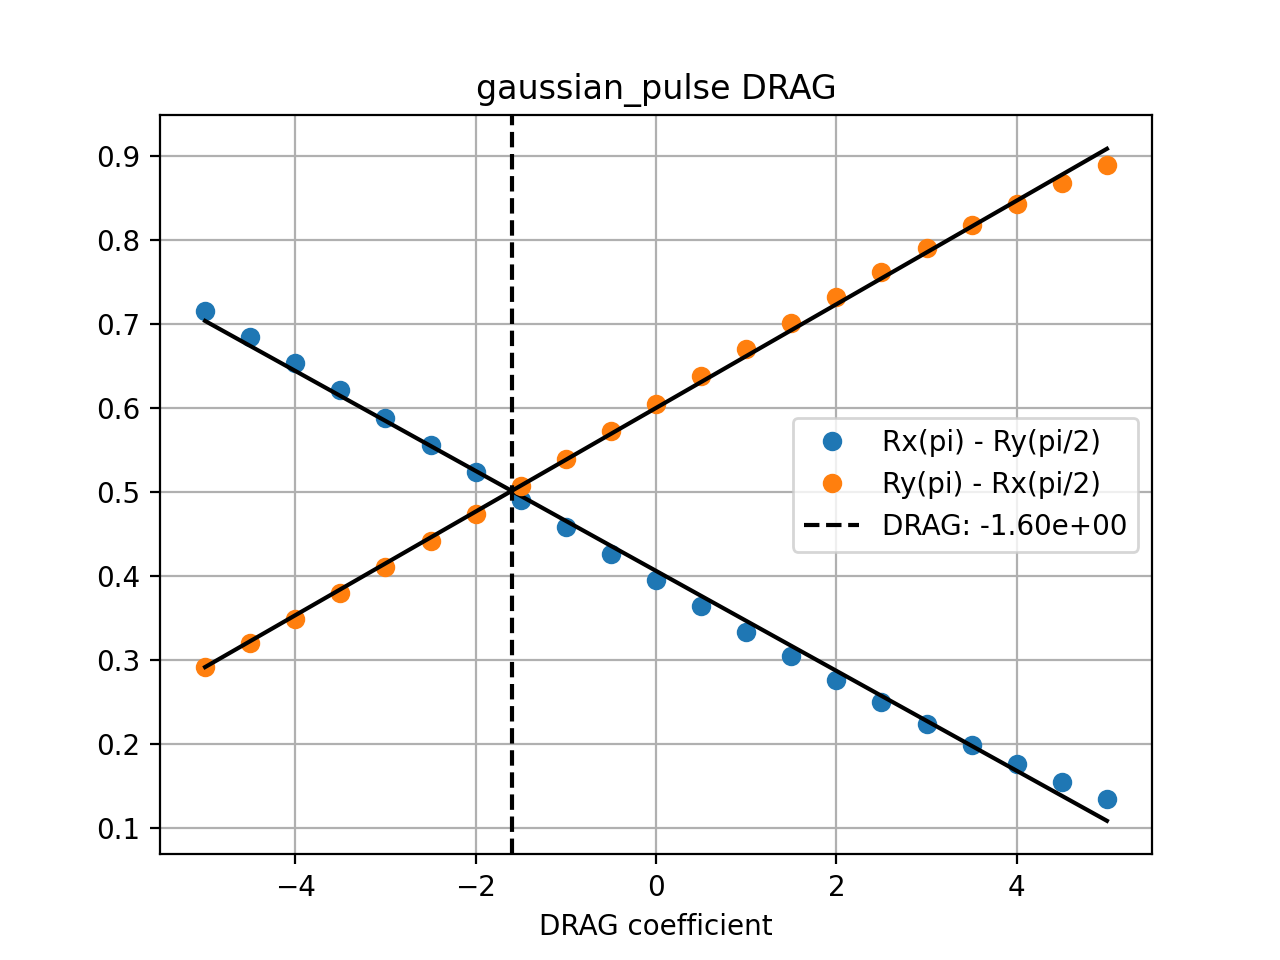

Updating gaussian_pulse.drag from 0.00e+00 to -1.60e+00.


In [15]:
_, old_drag, new_drag = tune_drag(
    system, init_state, mode_name='qubit', e_ops=[qubit.fock(1)]
)

<IPython.core.display.Javascript object>


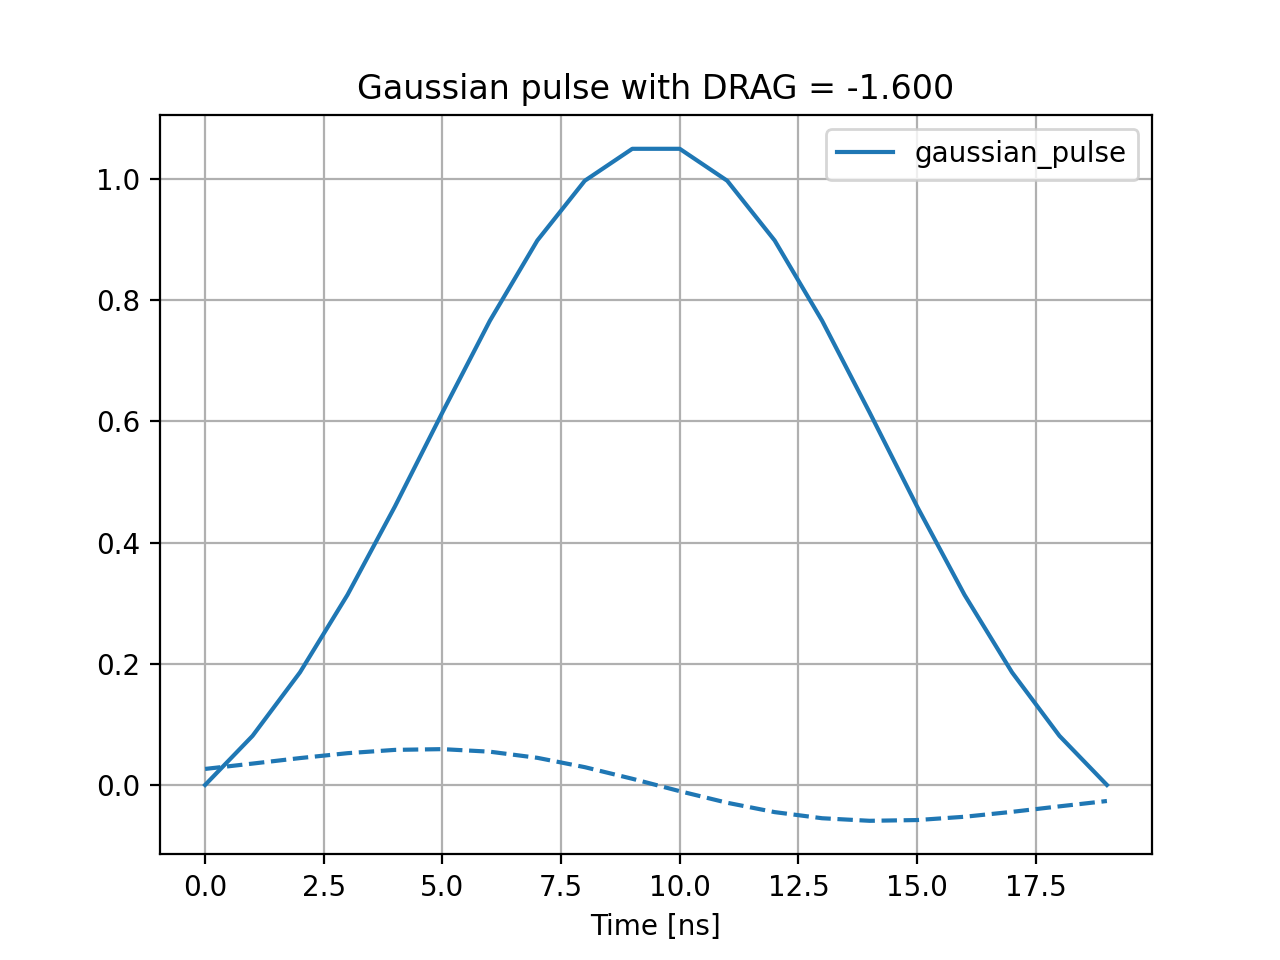

In [16]:
ax = qubit.gaussian_pulse.plot()
ax.set_xlabel('Time [ns]')
_ = ax.set_title(f'Gaussian pulse with DRAG = {new_drag:.3f}')

In [17]:
seq = get_sequence(system)
qubit.rotate_x(np.pi)
result = seq.run(init_state)
ideal_state = qubit.rotate_x(np.pi, unitary=True) * init_state
fid_g_to_e = qutip.fidelity(result.states[-1], ideal_state)**2
print(f'With DRAG - state fidelity |g> -> |e>: {fid_g_to_e:.5f}')

With DRAG - state fidelity |g> -> |e>: 0.99996


### Displacement

In [18]:
cavity = Cavity('cavity', levels=10)
system.modes = [qubit, cavity]
system.active_modes = [qubit, cavity]
system.set_cross_kerr(qubit, cavity, -2e-3) # set dispersive coupling to 2 MHz

The analogous tuneup sequence for a multilevel [Cavity](../api/classes.rst#Cavity) involves displacing the cavity with a gaussian pulse and then--because this is an experimentally convenient thing to do--measuring the probablity of the cavity being in fock state $|0\rangle$. Of course, because we have access to the full state of any quantum system we create using `sequencing`, we can directly calculate the probability of the cavity being in $|0\rangle$, $|1\rangle$, or any state we wish. This is what we do in the [built-in function](../api/functions.rst#tune-displacement) `sequencing.calibration.tune_displacement`, which is used to calibrate the cavity's `GaussianPulse`.

Note that, assuming the displacement pulse is correctly tuned, the x axis of the below plot is displacement amplitude $\alpha$, which has units of $\sqrt{\text{photons}}$, so at a pulse scale of 3, the cavity state is a coherent state with $\bar{n} = |\alpha|^2 = 9$.

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 17.72it/s]


<IPython.core.display.Javascript object>


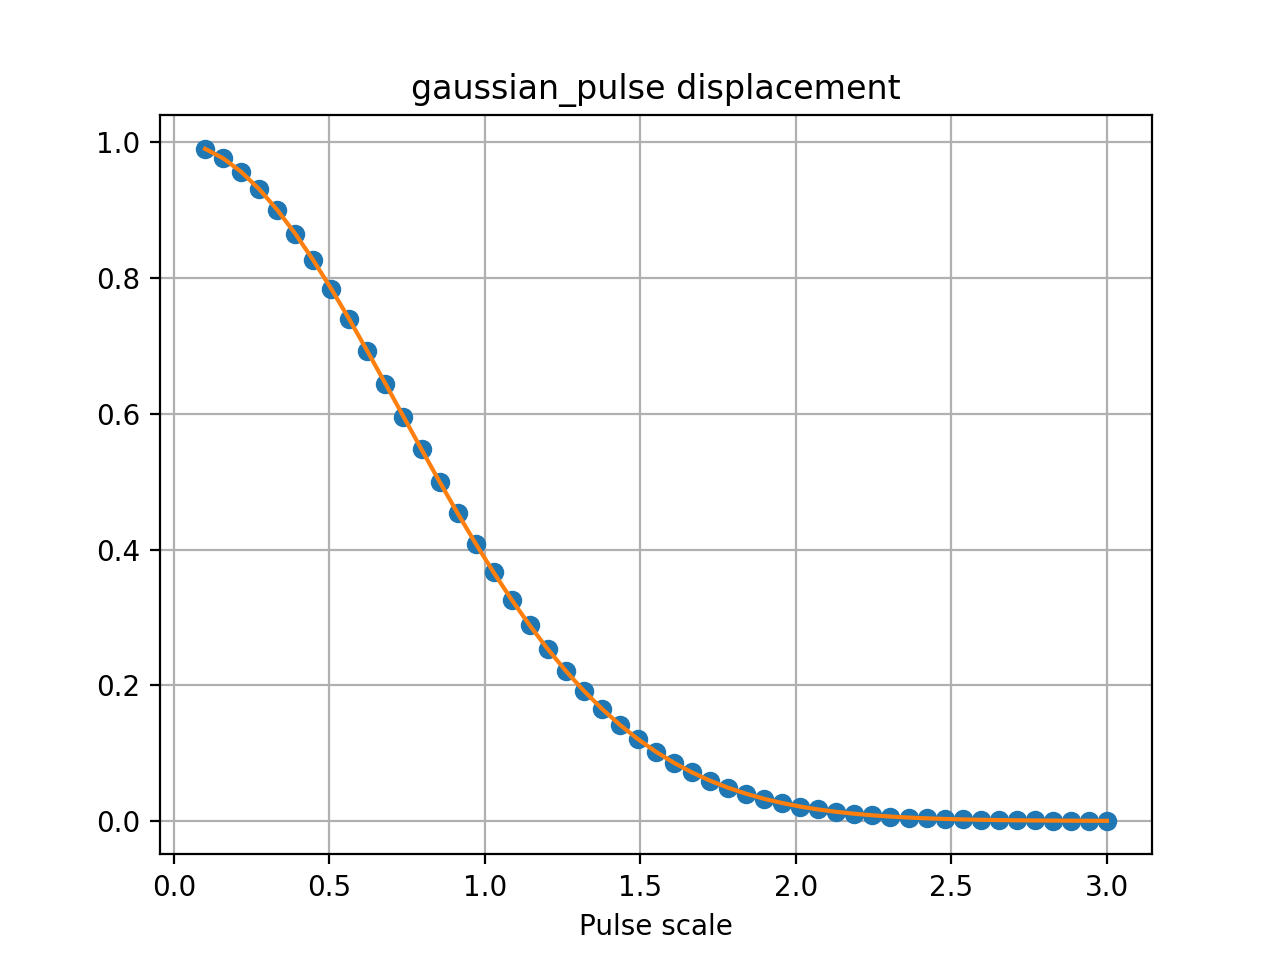

Updating cavity unit amp from 1.00e+00 to 1.03e+00.


In [19]:
init_state = system.ground_state()
_ = tune_displacement(system, init_state, verify=False)

Experimentally, it's not quite so easy - typically a cavity is measured by inferring its state based on its dispersive coupling to an ancilla qubit whose state can be measured with high fidelity. Below we will explore two pulse sequences that will allow us to infer the state of the cavity by measuring the state of the ancilla qubit. But first, we must desribe in more detail the operations that are available to us to control and measure a coupled qubit and cavity.

## Quantum control in the dispersive regime

There are five basic operations we can perform on a system composed of a qubit coupled to a cavity, assuming that we are in the number-resolved regime, i.e. the dispersive shift between cavity and qubit is large compared to their linewidths. Below, $n_c$ ($n_q$) represents the number of excitations in the cavity (qubit) and $I_c$ ($I_q$) represents the identity operator for the cavity (qubit).

1. **Transmon frequency *unselective* qubit rotations:** $R_\phi(\theta)$, implemented in `sequencing` by `qubit.rotate(theta, phi)` when the qubit pulse has a bandwidth $\gg\chi/2\pi$. This will rotate the qubit (approximately) independently of the state of the cavity. The wider the bandwidth (shorter the duration) of the qubit pulse, the better this approximation will be. This is the operation we tuned up in the [Rabi sequence](#Rabi) above.

1. **Transmon frequency *selective* qubit rotations:** $R_{\phi,n_c}(\theta) = |n_c\rangle\langle n_c|R_\phi(\theta) + (I_c-|n_c\rangle\langle n_c|)I_q$, implemented in `sequencing` by `qubit.rotate(theta, phi)` when the qubit pulse has a bandwidth $\ll\chi/2\pi$. This will rotate the qubit conditioned on the state of the cavity. Applying a selective qubit pulse at frequency $\omega_q-n_c|\chi|$ rotates the qubit if and only if there are $n_c$ photons in the cavity. As we will see below, we can use this operation followed by measuring the state of the qubit to answer the question "are there zero photons in the cavity?"

1. **Cavity frequency *unselective* displacements:** $D(\alpha)$, implemented in `sequencing` by `cavity.displace(alpha)` when the cavity pulse has a bandwidth $\gg\chi/2\pi$. This is the operation we tuned up in the [displacement sequence](#Displacement) above.

1. **Cavity frequency *selective* displacements:** $D_{n_q}(\alpha) = |n_q\rangle\langle n_q|D(\alpha) + (I_q-|n_q\rangle\langle n_q|)I_c$, implemented in `sequencing` by `cavity.displace(alpha)` when the cavity pulse has a bandwidth $\ll\chi/2\pi$. (Treating the qubit as a true two-level system, we have $|n_q\rangle\in\{|g\rangle,|e\rangle\}=\{|0\rangle,|1\rangle\}$.) Applying a selective cavity pulse at frequency $\omega_c-n_q|\chi|$ displaces the cavity if and only if the qubit is in state $|n_q\rangle$.

1. **Conditional phase:** $C_\phi=\exp(i\phi\,a^\dagger a\,|e\rangle\langle e|)$, where $a$ is the cavity annihillation operator. This is an entangling operation that can be used to impart a phase on the qubit conditioned on the state of the cavity (or vice-versa, of course). We can enact the operation $C_\phi$ by evolving the state of the system for a time $t=\phi/\chi$. As we will see below, we can use this operation followed by measuring the state of the qubit to answer the question "does the cavity state have even/odd parity?"

In [20]:
selective_sigma = 500 # ns

# tune selective qubit pulse using Rabi
with system.use_modes([qubit]):
    with qubit.temporarily_set(gaussian_pulse__sigma=selective_sigma):
        _, _, selective_qubit_amp = tune_rabi(
            system, qubit.fock(0), update=False, plot=False, verify=False
        )
        
# # tune selective cavity pulse using displacement
# with system.use_modes([cavity]):
#     with cavity.temporarily_set(gaussian_pulse__sigma=selective_sigma):
#         _, _, selective_cavity_amp = tune_displacement(
#             system, cavity.fock(0), update=False, plot=False, verify=False
#         )

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:17<00:00,  2.93it/s]


In [21]:
def selective_rotation(qubit, angle, phase=0, detune=0, sigma=selective_sigma):
    with qubit.gaussian_pulse.temporarily_set(sigma=sigma, amp=selective_qubit_amp):
         qubit.rotate(np.pi, phase, detune=detune)
        
# def selective_displacement(cavity, alpha, detune=0, sigma=selective_sigma):
#     with cavity.gaussian_pulse.temporarily_set(sigma=sigma, amp=selective_cavity_amp):
#         cavity.displace(alpha, detune=detune)

### Selective qubit rotation ($n = 0$)

First, let's use a selective qubit rotation to answer the question "are there 0 photons in the cavity?"

In [22]:
init_states = [
    (f'$|g{n}\\rangle$', system.fock(qubit=0, cavity=n)) for n in range(4)
]

In [23]:
# Apply a selective pi pulse that is resonant
# with the qubit when the cavity is in |0>.
results = {}

seq = get_sequence(system)
selective_rotation(qubit, np.pi)

for label, state in tqdm(init_states, desc='Initial states'):
    result = seq.run(state)
    results[label] = result

Initial states: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.21it/s]


<IPython.core.display.Javascript object>


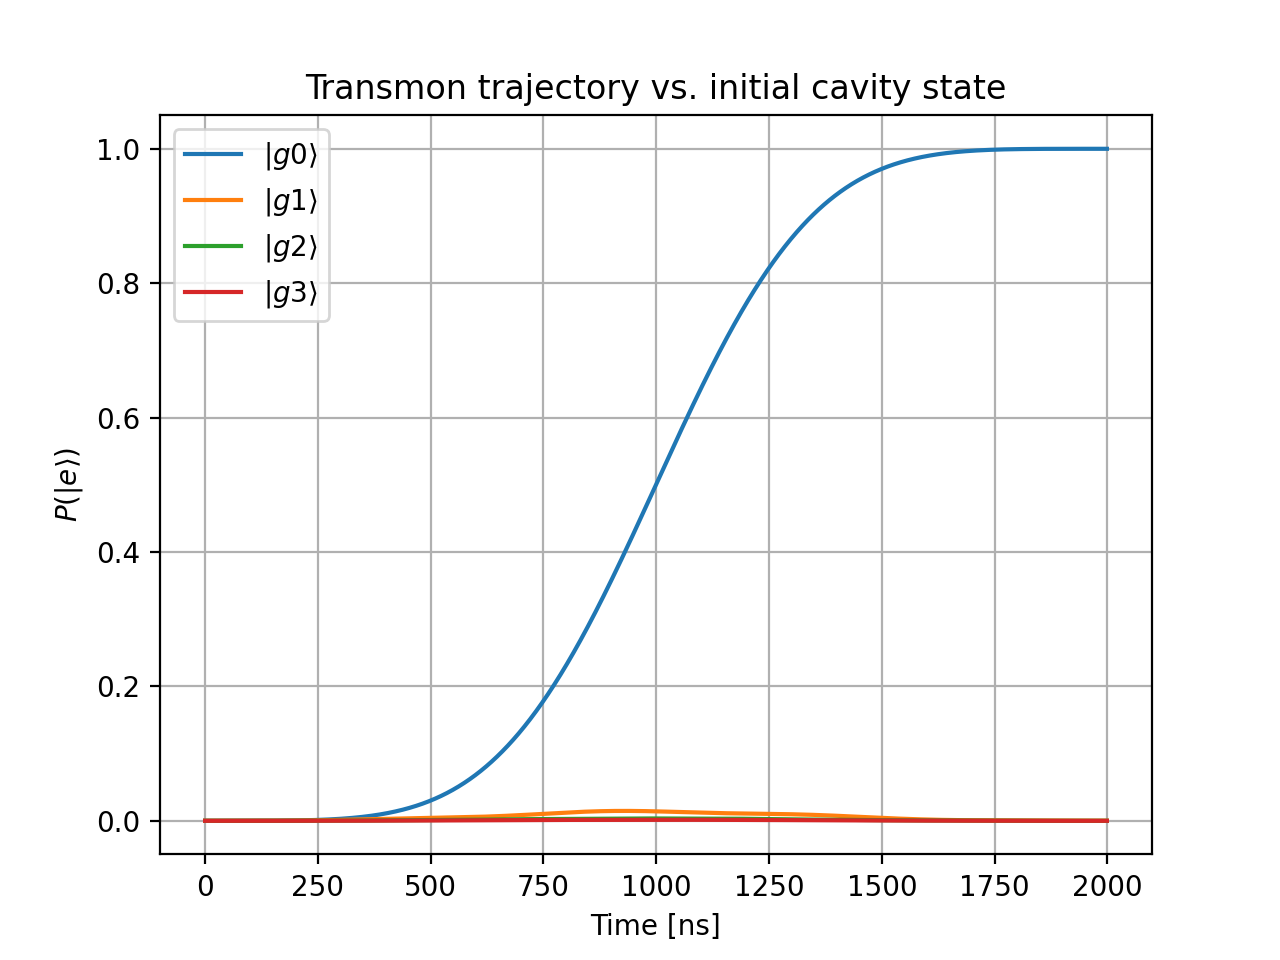

In [24]:
fig, ax = plt.subplots(1, 1)
for label, result in results.items():
    # trace over the cavity
    qubit_states = [state.ptrace(qubit.index) for state in result.states]
    e_pops = qutip.expect(qubit.fock_dm(1, full_space=False), qubit_states)
    ax.plot(result.times, e_pops, label=label)
    ax.grid(True)
    ax.legend(loc=0)
ax.set_xlabel('Time [ns]')
ax.set_ylabel(r'$P(|e\rangle)$')
_ = ax.set_title('Transmon trajectory vs. initial cavity state')

### Measuring the cavity using the qubit

As we can see, our sequence allows us to excite the transmon if and only if the cavity is in $|0\rangle$. Now let's use this selective pulse to measure the state of the cavity after a displacement.

In [25]:
init_state = system.ground_state()
# qubit in |e> after selective pi pulse means cavity in |0>
e_op = qubit.fock_dm(1, full_space=False)
disp_amps = np.linspace(0.01, 3, 21)
e_pops = []

for amp in tqdm(disp_amps, desc='Disp. amp.'):
    seq = get_sequence(system)
    
    cavity.displace(amp)
    sync()
    selective_rotation(qubit, np.pi)
    
    result = seq.run(init_state)
    # trace over the cavity
    transmon_state = result.states[-1].ptrace(qubit.index)
    e_pops.append(qutip.expect(e_op, transmon_state))

Disp. amp.: 100%|██████████████████████████████████████████████████████████████████████| 21/21 [00:18<00:00,  1.17it/s]


<IPython.core.display.Javascript object>


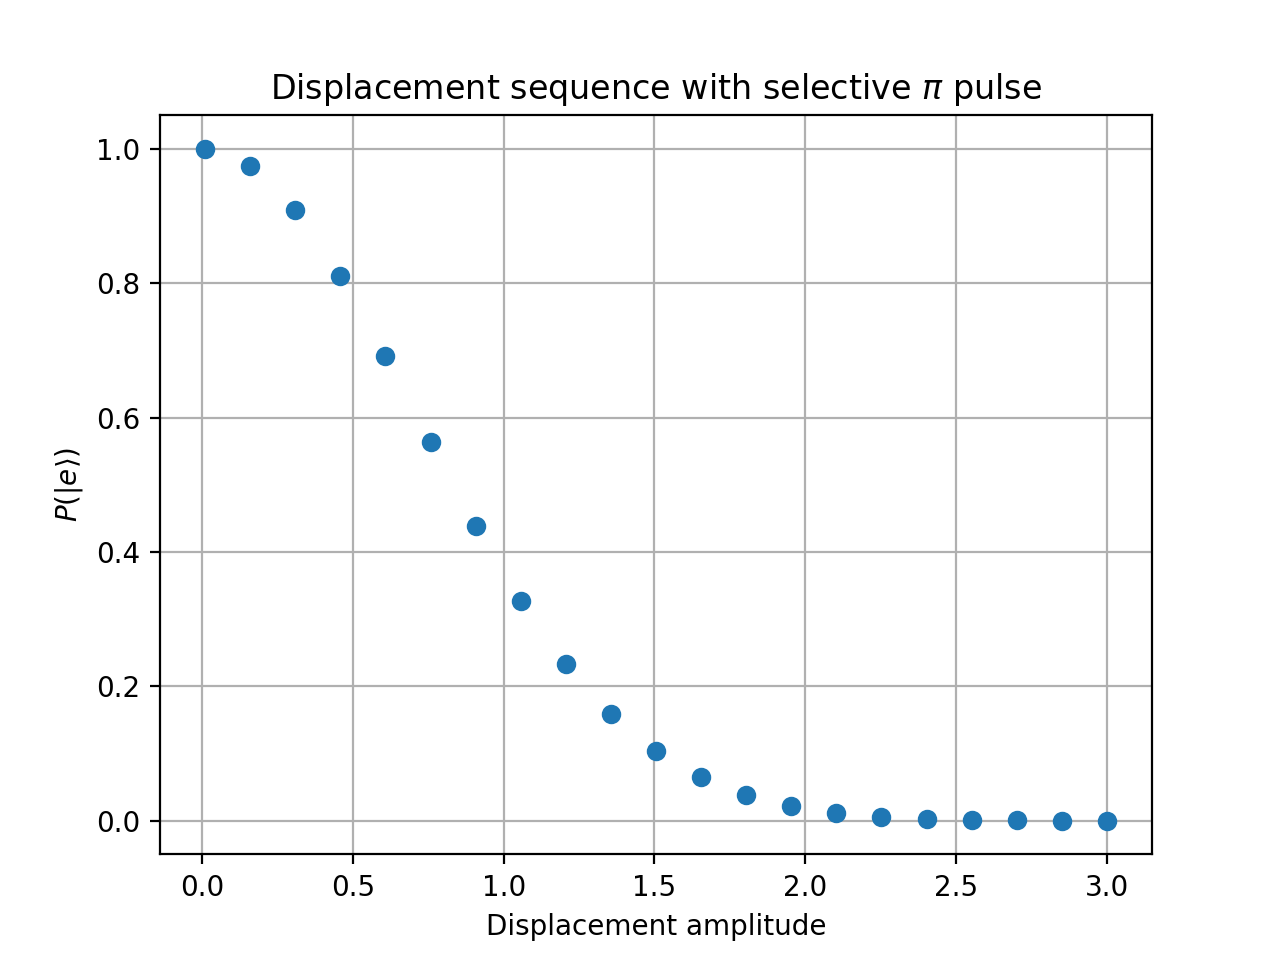

In [26]:
fig, ax = plt.subplots()
ax.plot(disp_amps, e_pops, 'o')
ax.grid(True)
ax.set_xlabel('Displacement amplitude')
ax.set_ylabel(r'$P(|e\rangle)$')
_ = ax.set_title(r'Displacement sequence with selective $\pi$ pulse')

Look familiar? This is the exact same sequence as our [displacement tuneup](#Displacement), with one crucial difference: in the default displacement tuneup sequence, the y axis the expectation value of the operator $|g0\rangle\langle g0|$, which we can only only measure in `sequencing` because we have access to the full joint state of the transmon-cavity system. On the other hand, using our selective $\pi$ pulse to infer the state of the cavity, we only need to measure the expectation value of an operator on the qubit: $|e\rangle\langle e|$. This means we can trace over the cavity while still learning information about its state.

### Selective $\pi$ pulse (any $n$)

Let's extend this sequence to answer the question "are there $n$ photons in the cavity?" for any $n$ we wish.

In [27]:
def rotate_qubit_on_n(system, n, angle, qubit_name='qubit', cavity_name='cavity'):
    """Rotate the qubit state iff the cavity is in state |n> by detuning
    the selective qubit pulse by n * chi.
    """
    qubit = system.get_mode(qubit_name)
    cavity = system.get_mode(cavity_name)
    chi = system.cross_kerrs[frozenset([qubit.name, cavity.name])]
    selective_rotation(qubit, angle, detune=n*chi)

Here we are applying a "detuning" to the qubit pulse by adding a time-dependent complex phase using the keyword argument `detune`. Let's examine the Hamiltonian coefficients for these detuned pulses.

<IPython.core.display.Javascript object>


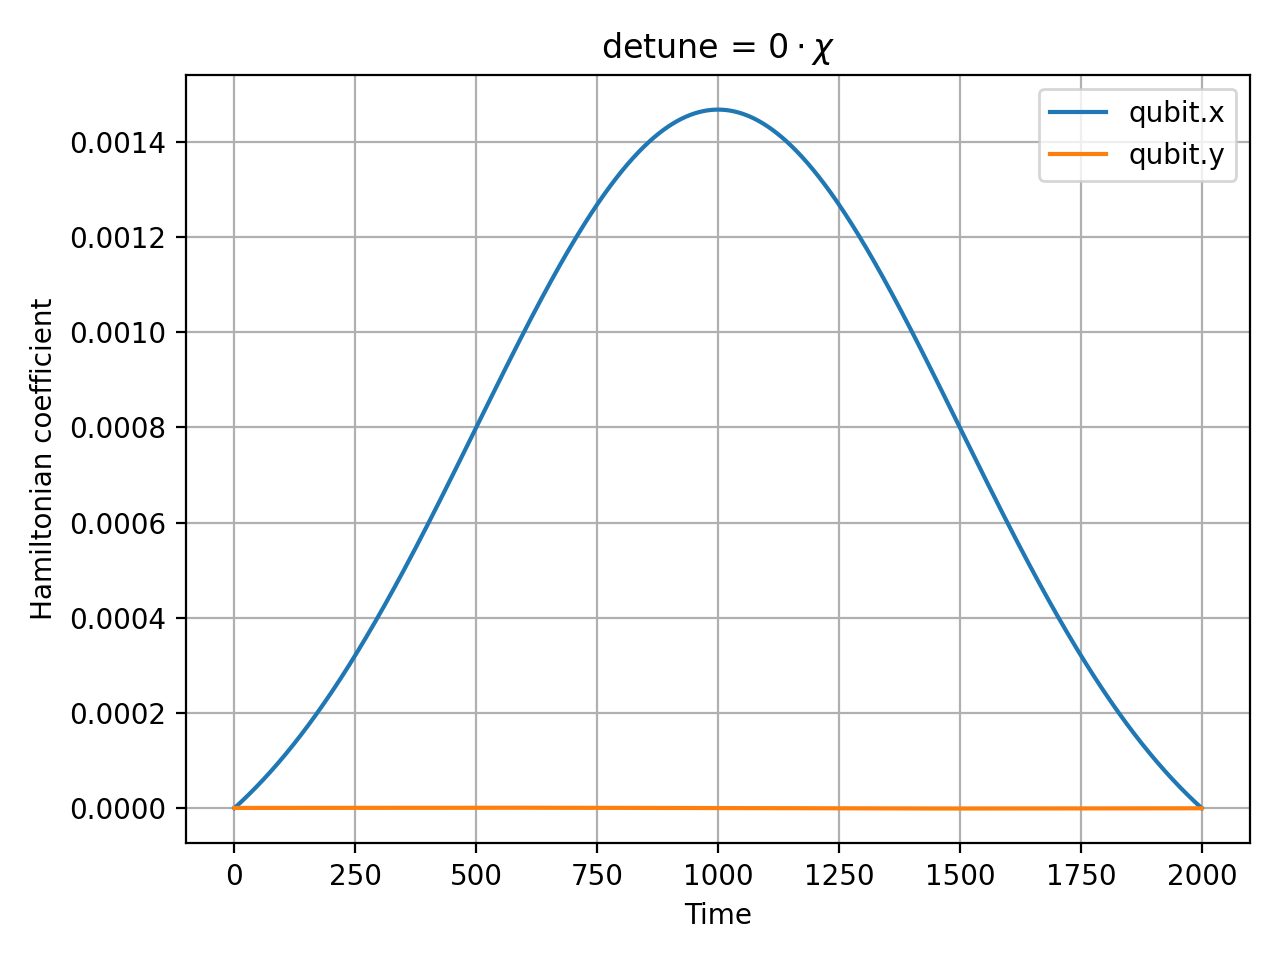

<IPython.core.display.Javascript object>


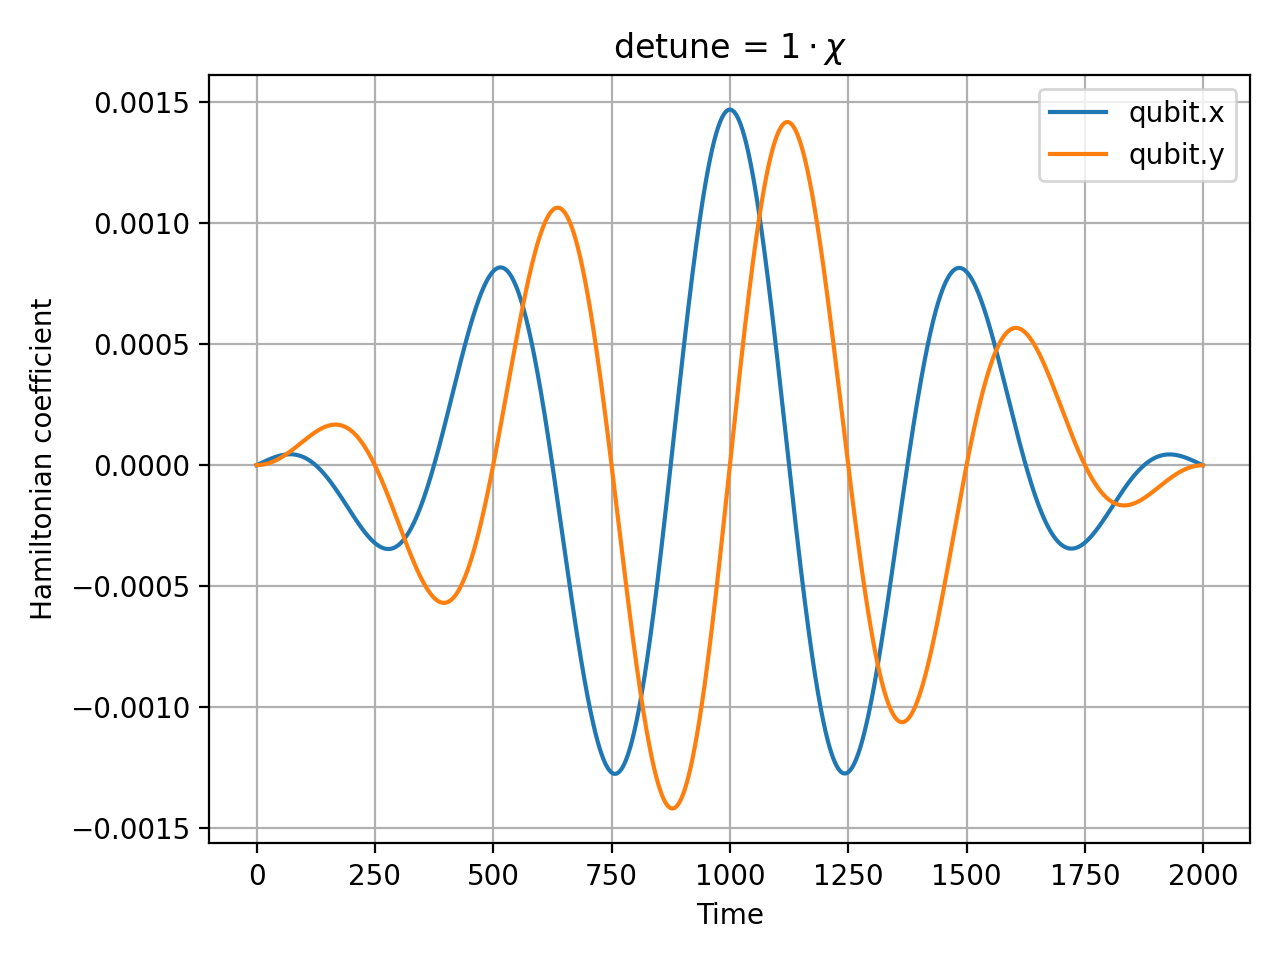

<IPython.core.display.Javascript object>


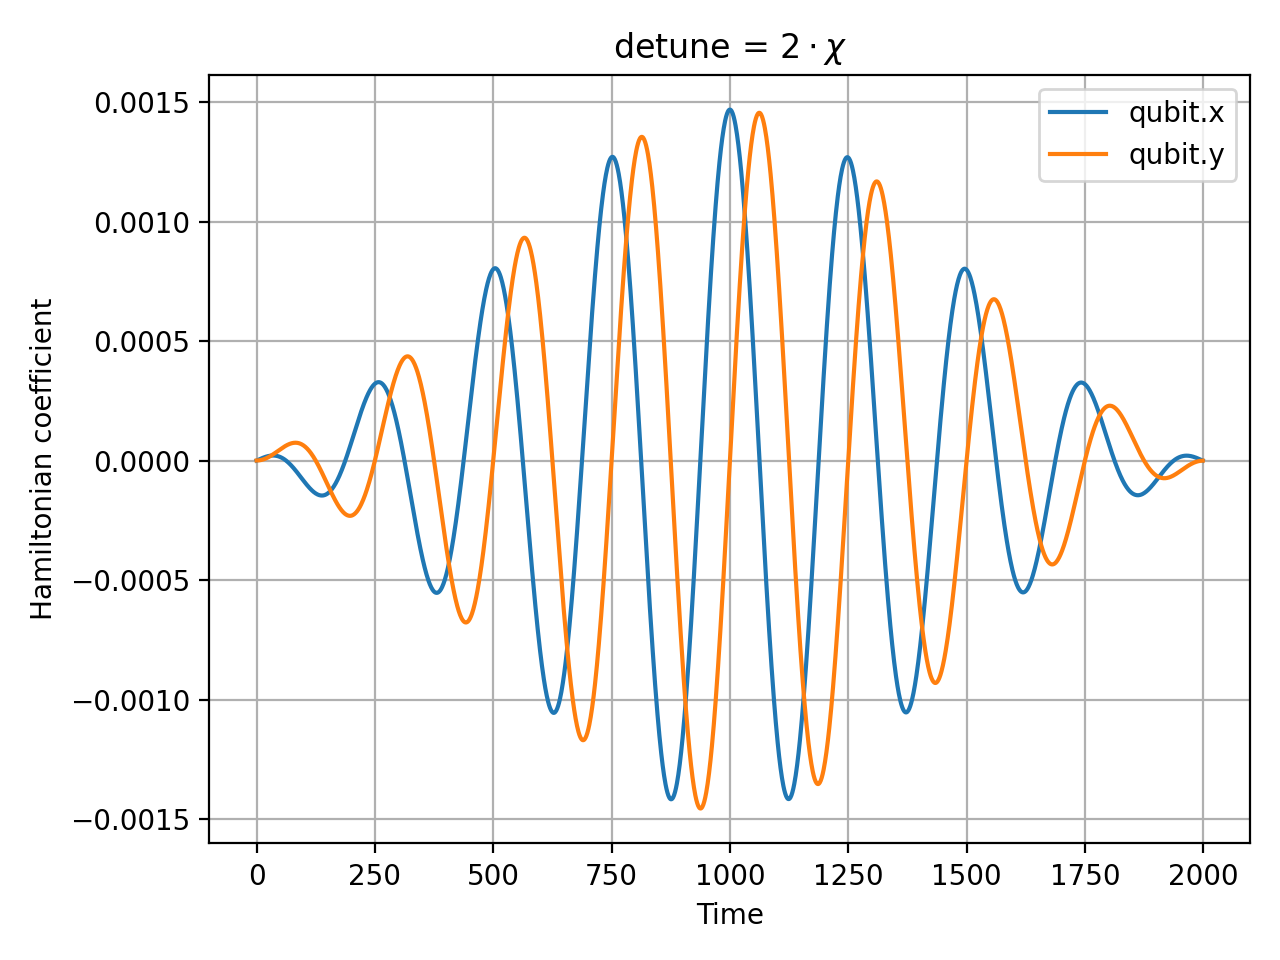

<IPython.core.display.Javascript object>


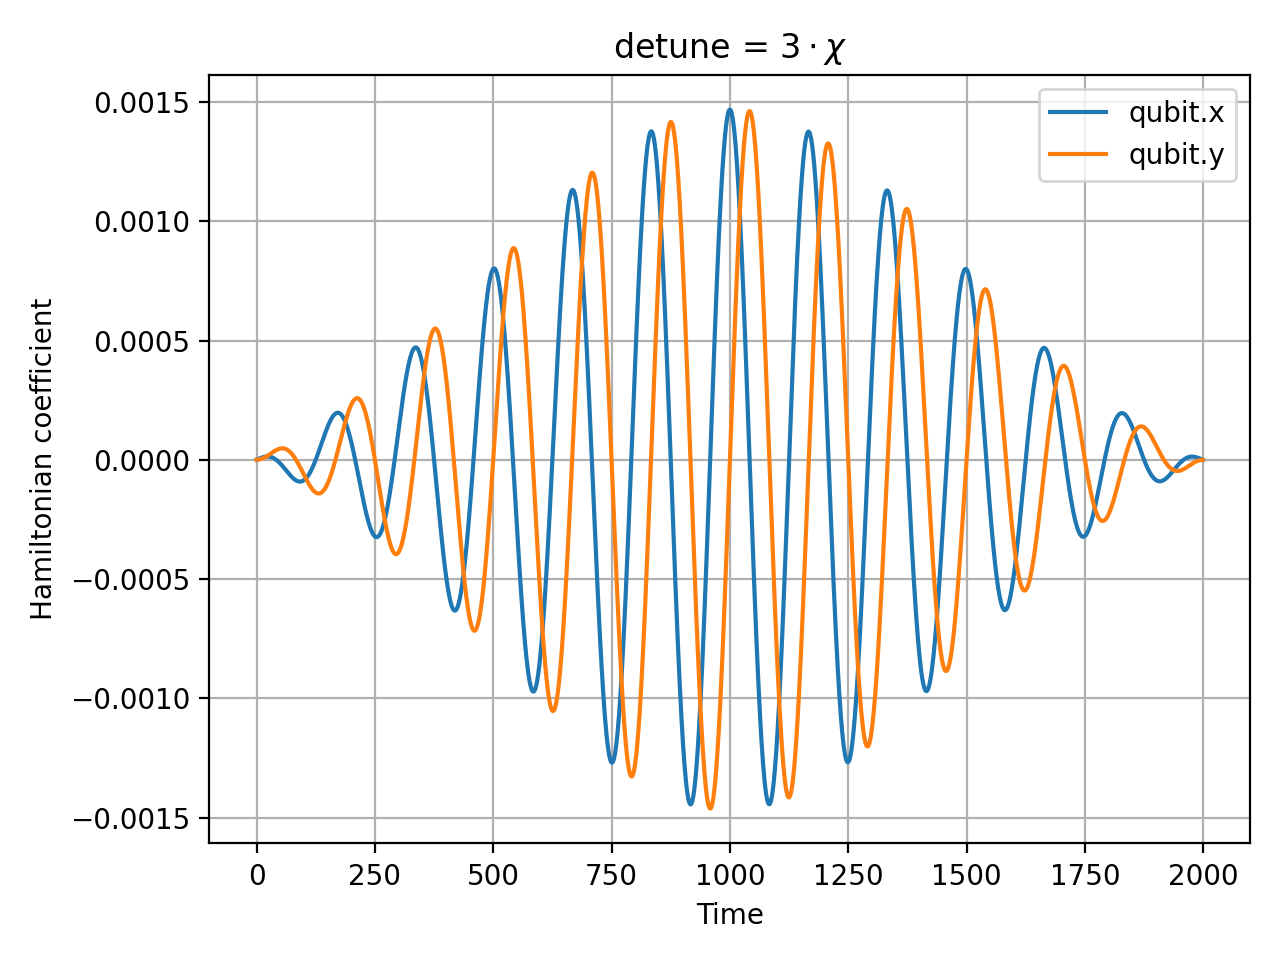

In [28]:
for n in range(4):
    seq = get_sequence(system)
    rotate_qubit_on_n(system, n, np.pi)
    fig, ax = seq.plot_coefficients(subplots=False)
    _ = ax.set_title(f'detune = ${n}\\cdot\\chi$')
    fig.tight_layout()

In [29]:
max_n = 4

init_states = [
    (f'$|g{n}\\rangle$', system.fock(qubit=0, cavity=n)) for n in range(max_n)
]

results = {}

for label, state in tqdm(init_states, desc='Initial states'):
    results[label] = []
    for n in range(max_n):
        seq = get_sequence(system)
        rotate_qubit_on_n(system, n, np.pi)
        result = seq.run(state)
        results[label].append(result)

Initial states: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.73s/it]


<IPython.core.display.Javascript object>


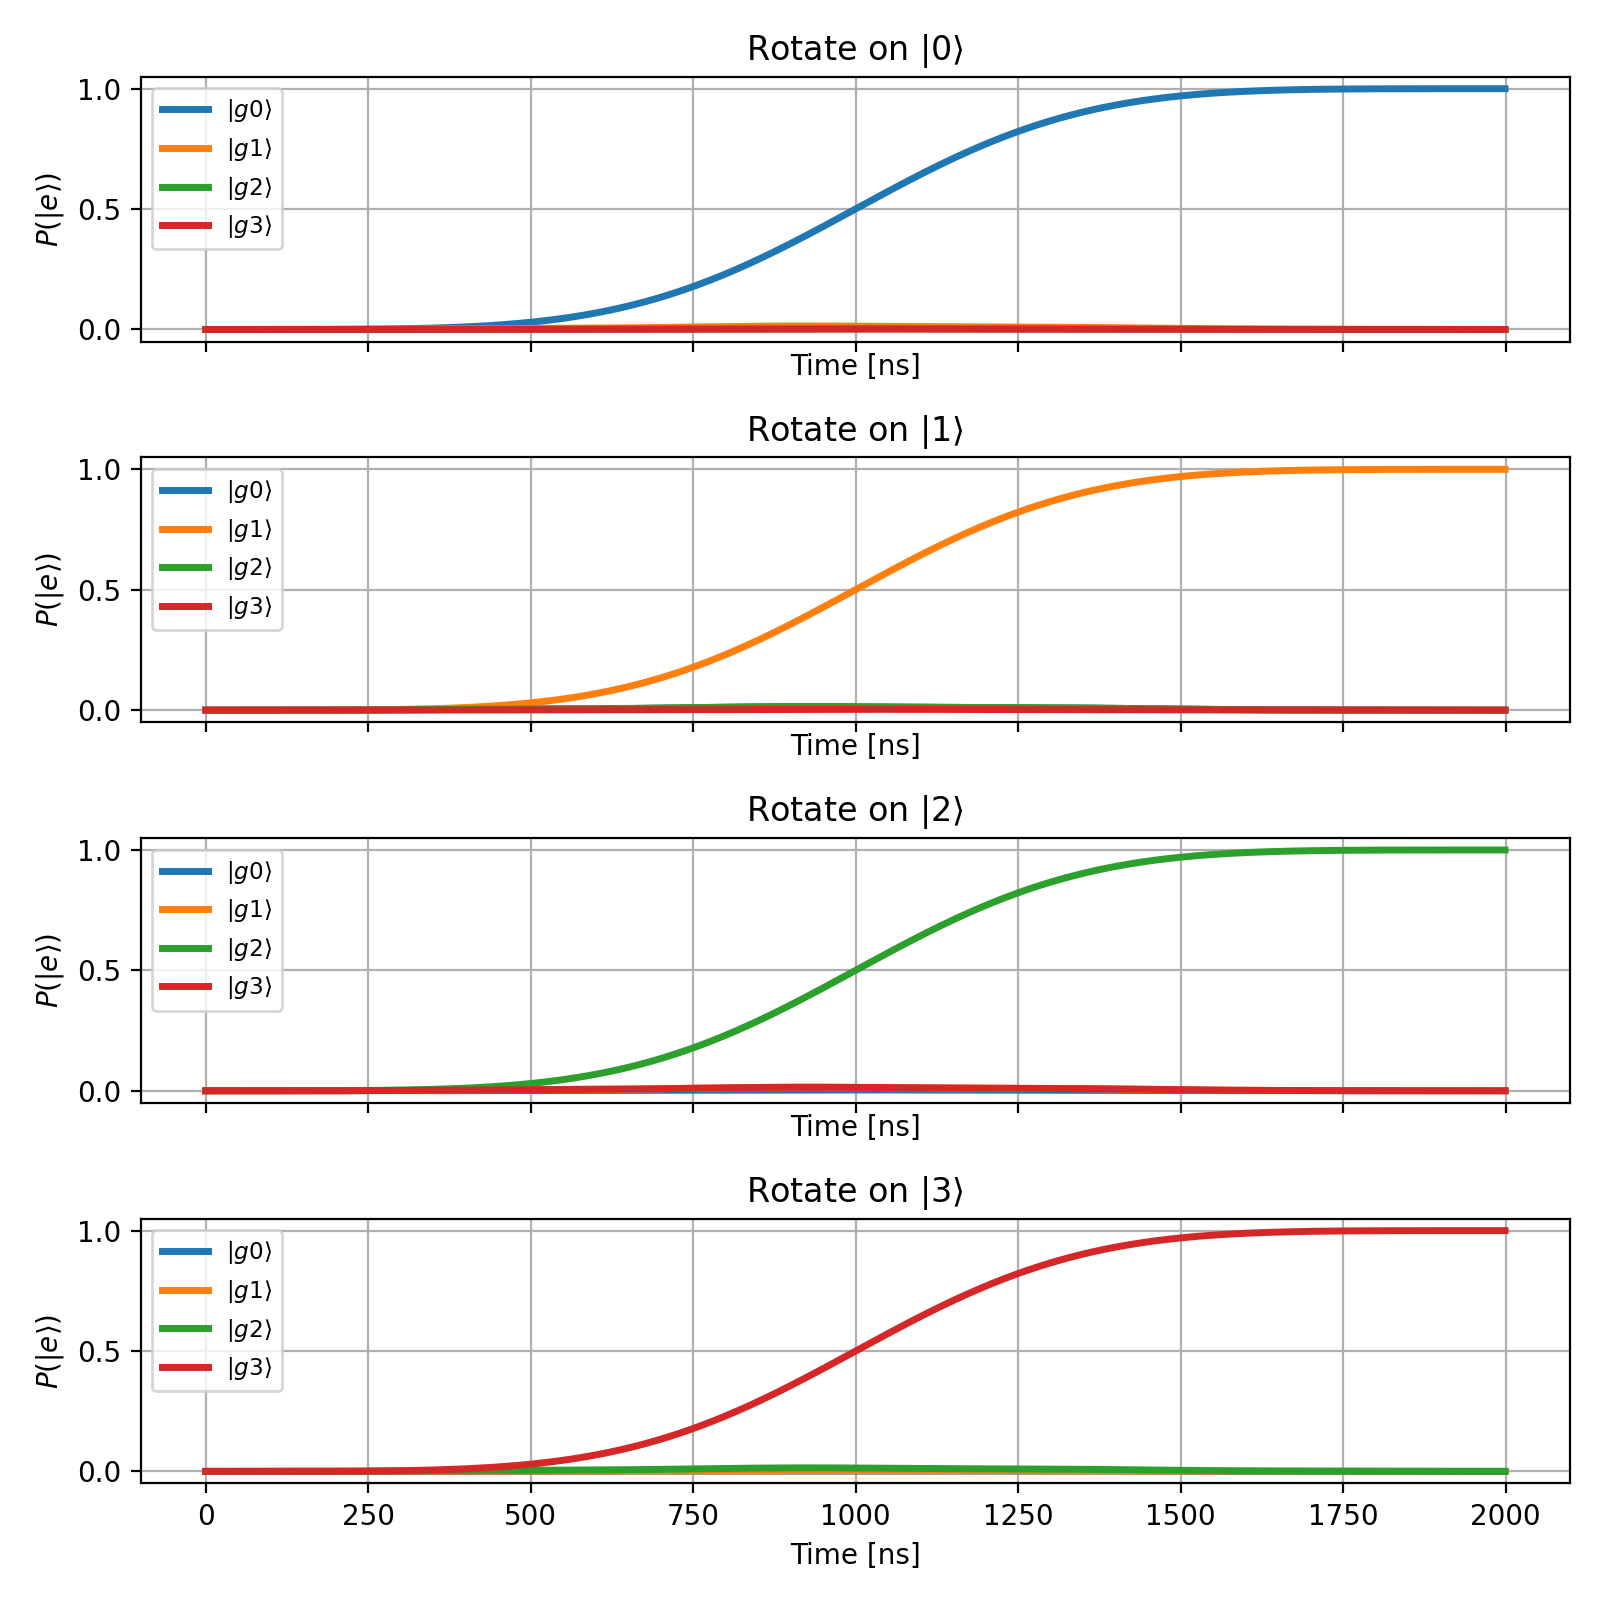

Plotting: 100%|██████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.38s/it]


In [30]:
fig, axes = plt.subplots(max_n, 1, sharex=True, sharey=True, figsize=(8,8))
e_op = qubit.fock_dm(1, full_space=False)
for label, results_list in tqdm(results.items(), desc='Plotting'):
    for ax, result_obj in zip(axes, results_list):
        xs = result_obj.times
        ys = [
            qutip.expect(e_op, state.ptrace(qubit.index))
            for state in result_obj.states
        ]
        ax.plot(xs, ys, lw=2.5, label=label)
        
for n, ax in enumerate(axes):
    ax.grid(True)
    ax.legend(loc=2, fontsize='small')
    ax.set_xlabel('Time [ns]')
    ax.set_ylabel(r'$P(|e\rangle)$')
    ax.set_title(f'Rotate on $|{n}\\rangle$')
fig.tight_layout()

Of course, if we wish to have easy access to a selective pulse, we can add it to our [Transmon](../api/classes.rst#Transmon) object using `Transmon.add_pulse()`:

In [31]:
print('sequencing.modes.PulseMode.add_pulse():')
print('\n\t'.join([''] + inspect.getdoc(Transmon.add_pulse).splitlines()))

sequencing.modes.PulseMode.add_pulse():

	Creates a new pulse of type ``cls`` and adds it to ``self.pulses``.
	
	Keyword arguments are passed to ``cls.__init__()``.
	
	Args:
	    cls (optional, type): Pulse class to instantiate.
	        Default: ``GaussianPulse``.
	    name (optional, str): Name of the new pulse. If None,
	        will use the "snake case" version of the class name,
	        e.g. "GaussianPulse" -> "gaussian_pulse". Default: None.
	    error_if_exists (optional, bool): Whether to raise an exception
	        if a pulse with the same name already exists. Default: False.


In [32]:
qubit.add_pulse(
    name='selective_gaussian_pulse',
    sigma=500, amp=selective_qubit_amp
)

<IPython.core.display.Javascript object>


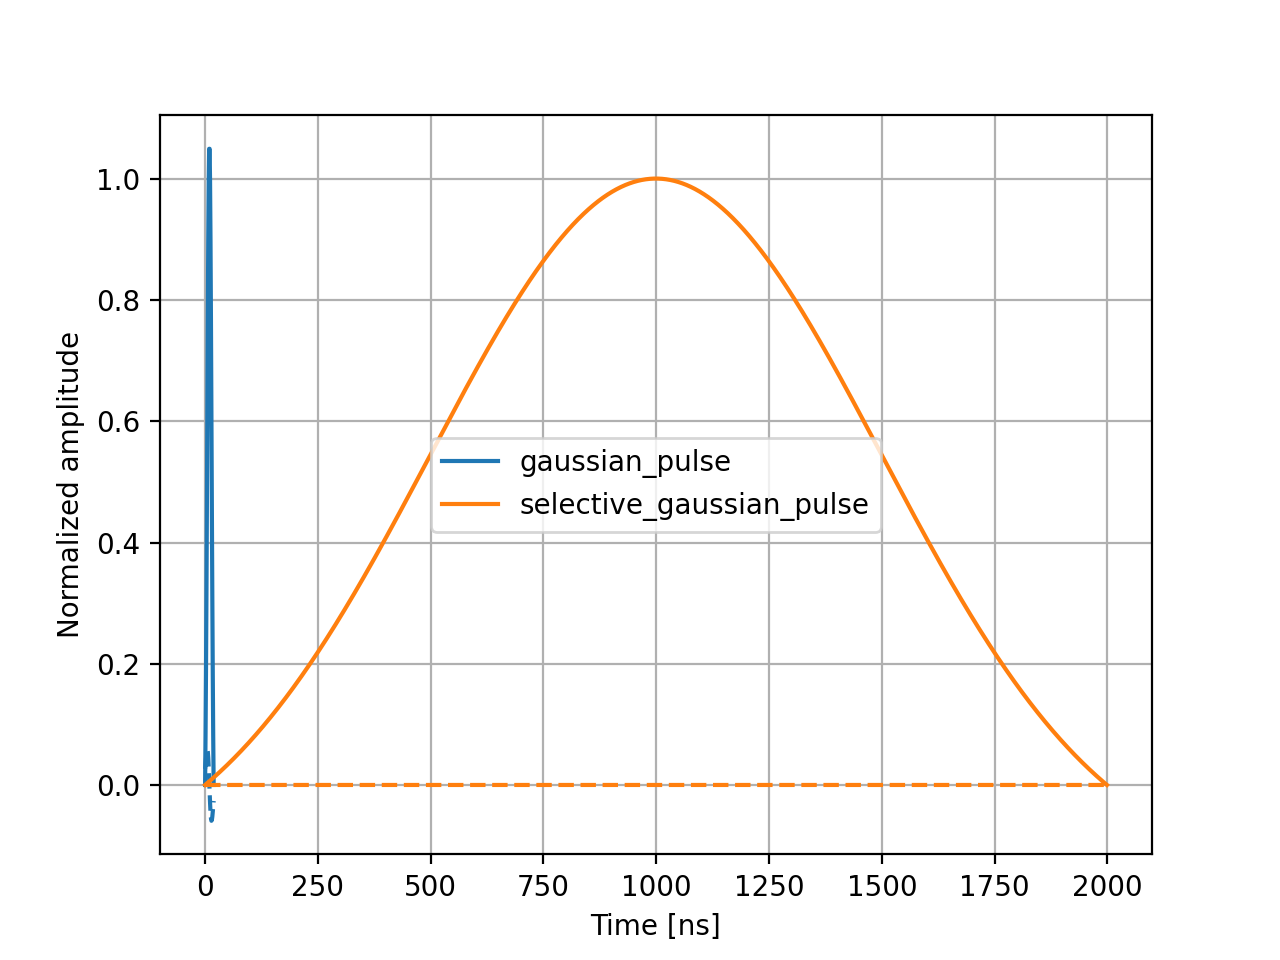

In [33]:
ax = qubit.gaussian_pulse.plot()
_ = qubit.selective_gaussian_pulse.plot(ax=ax)
ax.set_xlabel('Time [ns]')
ax = ax.set_ylabel('Normalized amplitude')

In [34]:
print(list(qubit.pulses))

['smoothed_constant_pulse', 'gaussian_pulse', 'selective_gaussian_pulse']


Now we can repeat our [displacement sequence using a selective transmon pulse to measure the cavity](#Measuring-the-cavity-using-the-qubit), this time measuring on different photon number peaks.

In [35]:
max_n = 4

init_state = system.ground_state()
# qubit in |e> after selective pi pulse means cavity in |n>
e_op = qubit.fock_dm(1, full_space=False)
disp_amps = np.linspace(0.01, 3, 21)
e_pops = []

for n in range(max_n):
    e_pops.append([])
    for amp in tqdm(disp_amps, desc=f'Disp. amp. (measure n={n})'):
        seq = get_sequence(system)

        cavity.displace(amp)
        sync()
        rotate_qubit_on_n(system, n, np.pi)
        result = seq.run(init_state)
        # trace over the cavity
        transmon_state = result.states[-1].ptrace(qubit.index)
        e_pops[-1].append(qutip.expect(e_op, transmon_state))

Disp. amp. (measure n=3): 100%|████████████████████████████████████████████████████████| 21/21 [00:17<00:00,  1.23it/s]


<IPython.core.display.Javascript object>


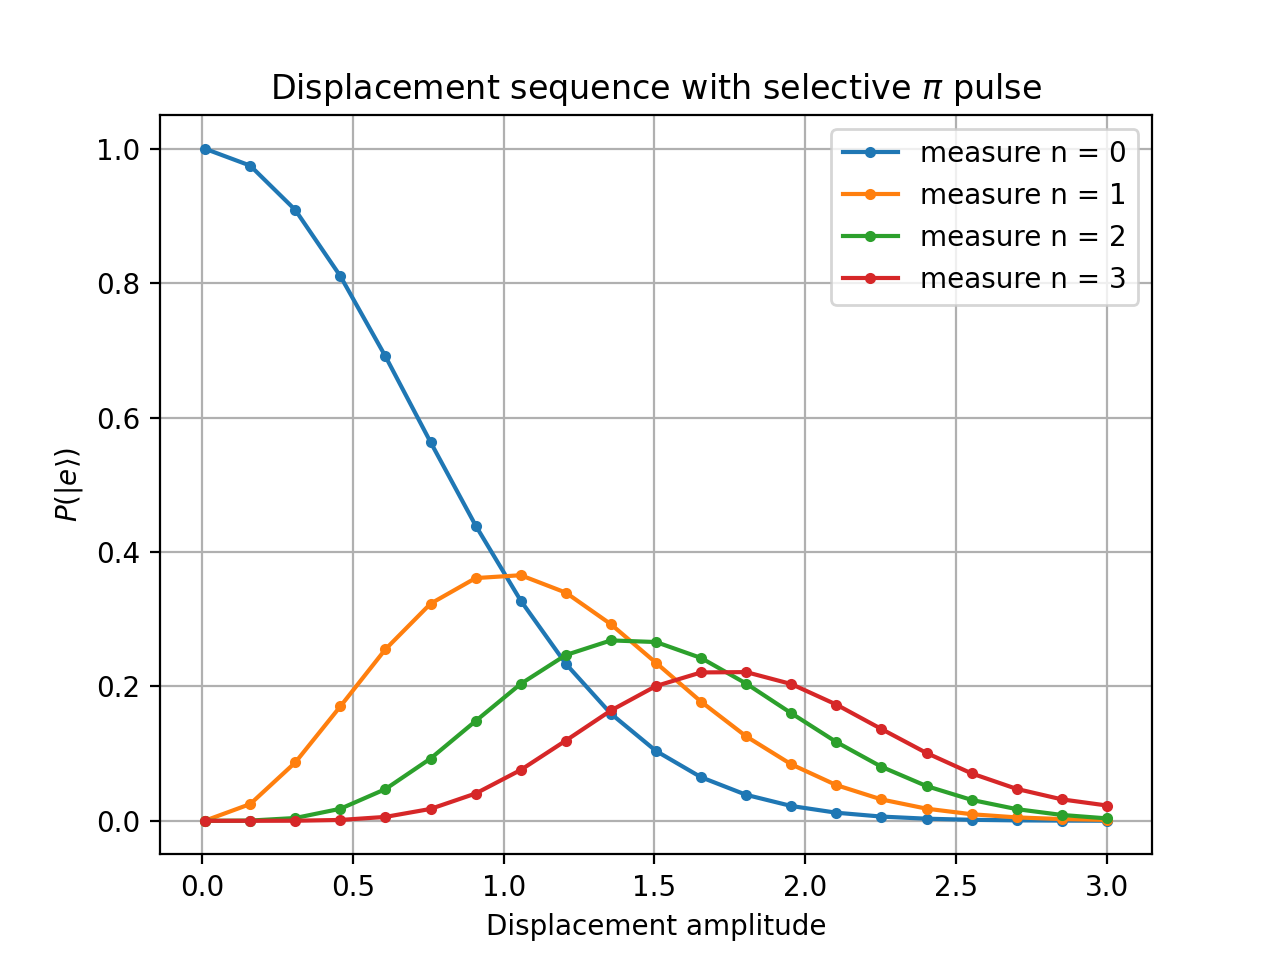

In [36]:
fig, ax = plt.subplots()
for n, es in enumerate(e_pops):
    ax.plot(disp_amps, es, '.-', label=f'measure n = {n}')
ax.legend(loc=0)
ax.grid(True)
ax.set_xlabel('Displacement amplitude')
ax.set_ylabel(r'$P(|e\rangle)$')
_ = ax.set_title(r'Displacement sequence with selective $\pi$ pulse')

### Parity mapping

We can measure the photon number parity of the cavity state using the **conditional phase** operation $C_\phi=\exp(i\phi\,a^\dagger a\,|e\rangle\langle e|)$. Let's define the parity operator $\Pi = e^{i\pi a^\dagger a} = (-1)^{a^\dagger a}$, where $a$ is the annihilation operator for the cavity. The expectation value of $\Pi$ is +1 if there are an even number of photons in the cavity and -1 if there are an odd number of photons. If we take $\phi = \pi$, we can write the conditional phase $C_\pi$ in terms of the parity operator:
$$C_\pi = I_c|g\rangle\langle g| + \Pi|e\rangle\langle e|$$

We can think of this operator in two ways:

1. $C_\pi$ flips the phase of the qubit state iff there are an odd number of photons in the cavity, or
1. $C_\pi$ flips the phase of all odd-parity cavity states iff the qubit is in $|e\rangle$

If we sandwich $C_\pi$ between two entangling **unselective** $\pi/2$ pulses on the qubit, we can map the photon number parity of the cavity state onto the qubit state: $R(\pi/2)C_\pi R(-\pi/2)$ maps even parity to $|g\rangle$ and odd parity to $|e\rangle$. If we flip the phase of the second $\pi/2$ pulse, we can instead map even parity to $|e\rangle$ and odd parity to $|g\rangle$

In [37]:
def parity_map(
        system, t_adjust=0, axis=np.pi, map_odd_to_e=True,
        qubit_name='qubit', cavity_name='cavity'
        ):
    qubit = system.get_mode(qubit_name)
    cavity = system.get_mode(cavity_name)
    chi = system.cross_kerrs[frozenset([qubit.name, cavity.name])]
    mapping_time = np.pi / (2 * np.pi * abs(chi))
    # correct for the non-zero pulse length
    pulse_length = qubit.gaussian_pulse.sigma * qubit.gaussian_pulse.chop
    delay_time = mapping_time - pulse_length + t_adjust
    
    # pulse sequence
    sync()
    # R(-\pi/2)
    qubit.rotate(-np.pi/2, axis)
    # C_\pi
    delay(delay_time)
    if map_odd_to_e:
        # R(\pi/2)
        qubit.rotate(np.pi/2, axis)
    else:
        # R(-\pi/2)
        qubit.rotate(-np.pi/2, axis)
    sync()

The intuition for this sequence is as follows:

We first perform an unselective $\pi/2$-pulse on the transmon, placing it in the state $|g\rangle+e^{i\phi}|e\rangle=|0\rangle+e^{i\phi}|1\rangle$. When the transmon is in $|1\rangle$, its phase evolves at a rate given by the number of photons in the cavity and the dispersive shift between transmon and cavity, $a^\dagger a \chi = a^\dagger a \times 2\pi\times2\text{ MHz}$. Therefore, if we wait for a time $t=\phi/\chi$ after the first $\pi/2$ pulse, the qubit state will accumulate a phase of $a^\dagger a \phi$. Let's take $\phi = \pi$ once again, and list the phase $\Delta\phi$ accumulated by the qubit when it is in $|e\rangle$ as a function of cavity photon number $n_c$:

- $n_c = 0$: $\Delta\phi = 0\times\pi,\:\Delta\phi\mod2\pi = 0$
- $n_c = 1$: $\Delta\phi = 1\times\pi,\:\Delta\phi\mod2\pi = \pi$
- $n_c = 2$: $\Delta\phi = 2\times\pi,\:\Delta\phi\mod2\pi = 0$
- $n_c = 3$: $\Delta\phi = 3\times\pi,\:\Delta\phi\mod2\pi = \pi$

Now a second $\pi/2$ pulse with the opposite sign with rotate the qubit back to $|g\rangle$ iff $\Delta\phi\mod2\pi=0$ or up to $|e\rangle$ iff $\Delta\phi\mod2\pi=\pi$, giving us our parity map.

Note that for our system, the idle time required for the conditional phase operation $C_\pi$ is $t=\pi/\chi = \pi / (2\times 2\pi\times 2\text{ MHz}) = 250\text{ ns}$. Adding the length of our two $\pi/2$ pulses: `2 * qubit.gaussian_pulse.sigma * qubit.gaussian_pulse.chop = 2 * 5 * 4 = 40` ns, we get a total time of 290 ns for the parity mapping operation. This is significantly faster than the cavity measurement using a selective $\pi$ pulse: `qubit.selective_gaussian_pulse.sigma * qubit.selective_gaussian_pulse.chop = 500 * 4 = 2000` ns. This means that for systems with finite coherence times, measuring the cavity state using parity mapping has the potential to have much higher fidelity than measuring the cavity with a selective qubit pulse.

In practice the mapping time $\pi/\chi$ may not be exactly optimal (for example, due to the finite length of the $R(\pi/2)$ operations), resulting in residual entanglement between the qubit and cavity after the second $\pi/2$ pulse. So we will write a sequence to find the optimal adjustment `t_adjust` to $t=\pi/\chi$.

In [38]:
init_state = system.fock(qubit=0, cavity=1)
e_op = qubit.fock_dm(1, full_space=False)
e_pops = []
times = np.linspace(-10,10,21)
for t in tqdm(times, desc='Times'):
    seq = get_sequence(system)
    parity_map(system, t_adjust=t)
    result = seq.run(init_state)
    e_pops.append(
        qutip.expect(e_op, result.states[-1].ptrace(qubit.index))
    )
i_opt = np.argmax(e_pops)
t_opt = times[i_opt]
e_opt = e_pops[i_opt]

Times: 100%|███████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.51it/s]


<IPython.core.display.Javascript object>


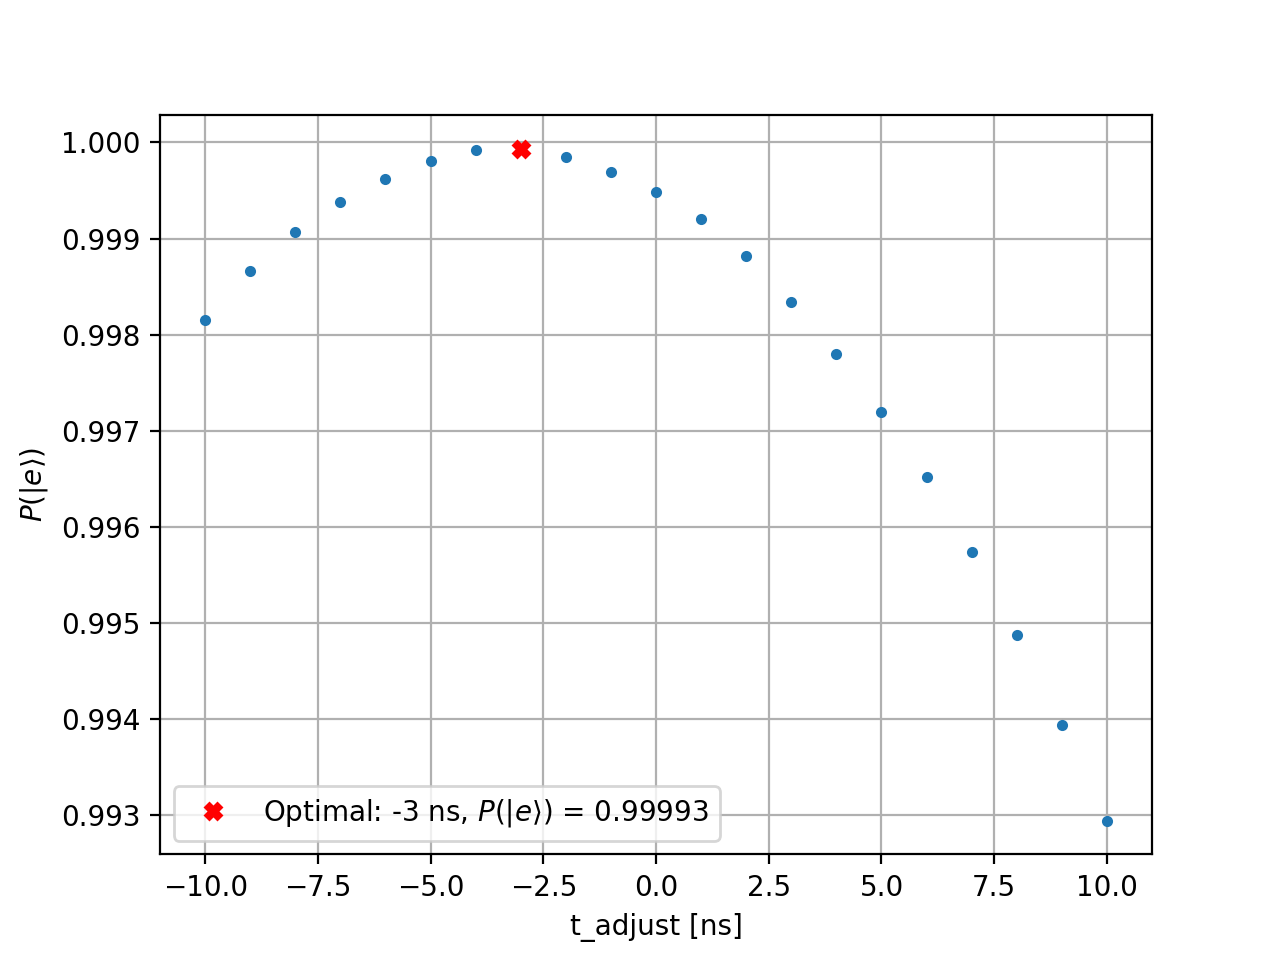

In [39]:
fig, ax = plt.subplots()
ax.plot(times, e_pops, '.')
ax.plot(
    [t_opt], [e_opt], 'rX',
    label=f'Optimal: {t_opt:.0f} ns, $P(|e\\rangle)$ = {e_opt:.5f}'
)
ax.grid(True)
ax.legend(loc=0)
ax.set_xlabel('t_adjust [ns]')
_ = ax.set_ylabel(r'$P(|e\rangle)$')

In [40]:
max_n = 4

init_states = [
    (f'$|g{n}\\rangle$', system.fock(qubit=0, cavity=n)) for n in range(max_n)
]

odd_to_e_results = {}

seq = get_sequence(system)
parity_map(system, t_adjust=t_opt, map_odd_to_e=True)

for label, state in tqdm(init_states, desc='Initial states'):
    result = seq.run(state)
    odd_to_e_results[label] = result
    
odd_to_g_results = {}

seq = get_sequence(system)
parity_map(system, t_adjust=t_opt, map_odd_to_e=False)

for label, state in tqdm(init_states, desc='Initial states'):
    result = seq.run(state)
    odd_to_g_results[label] = result

Initial states: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.49it/s]


<IPython.core.display.Javascript object>


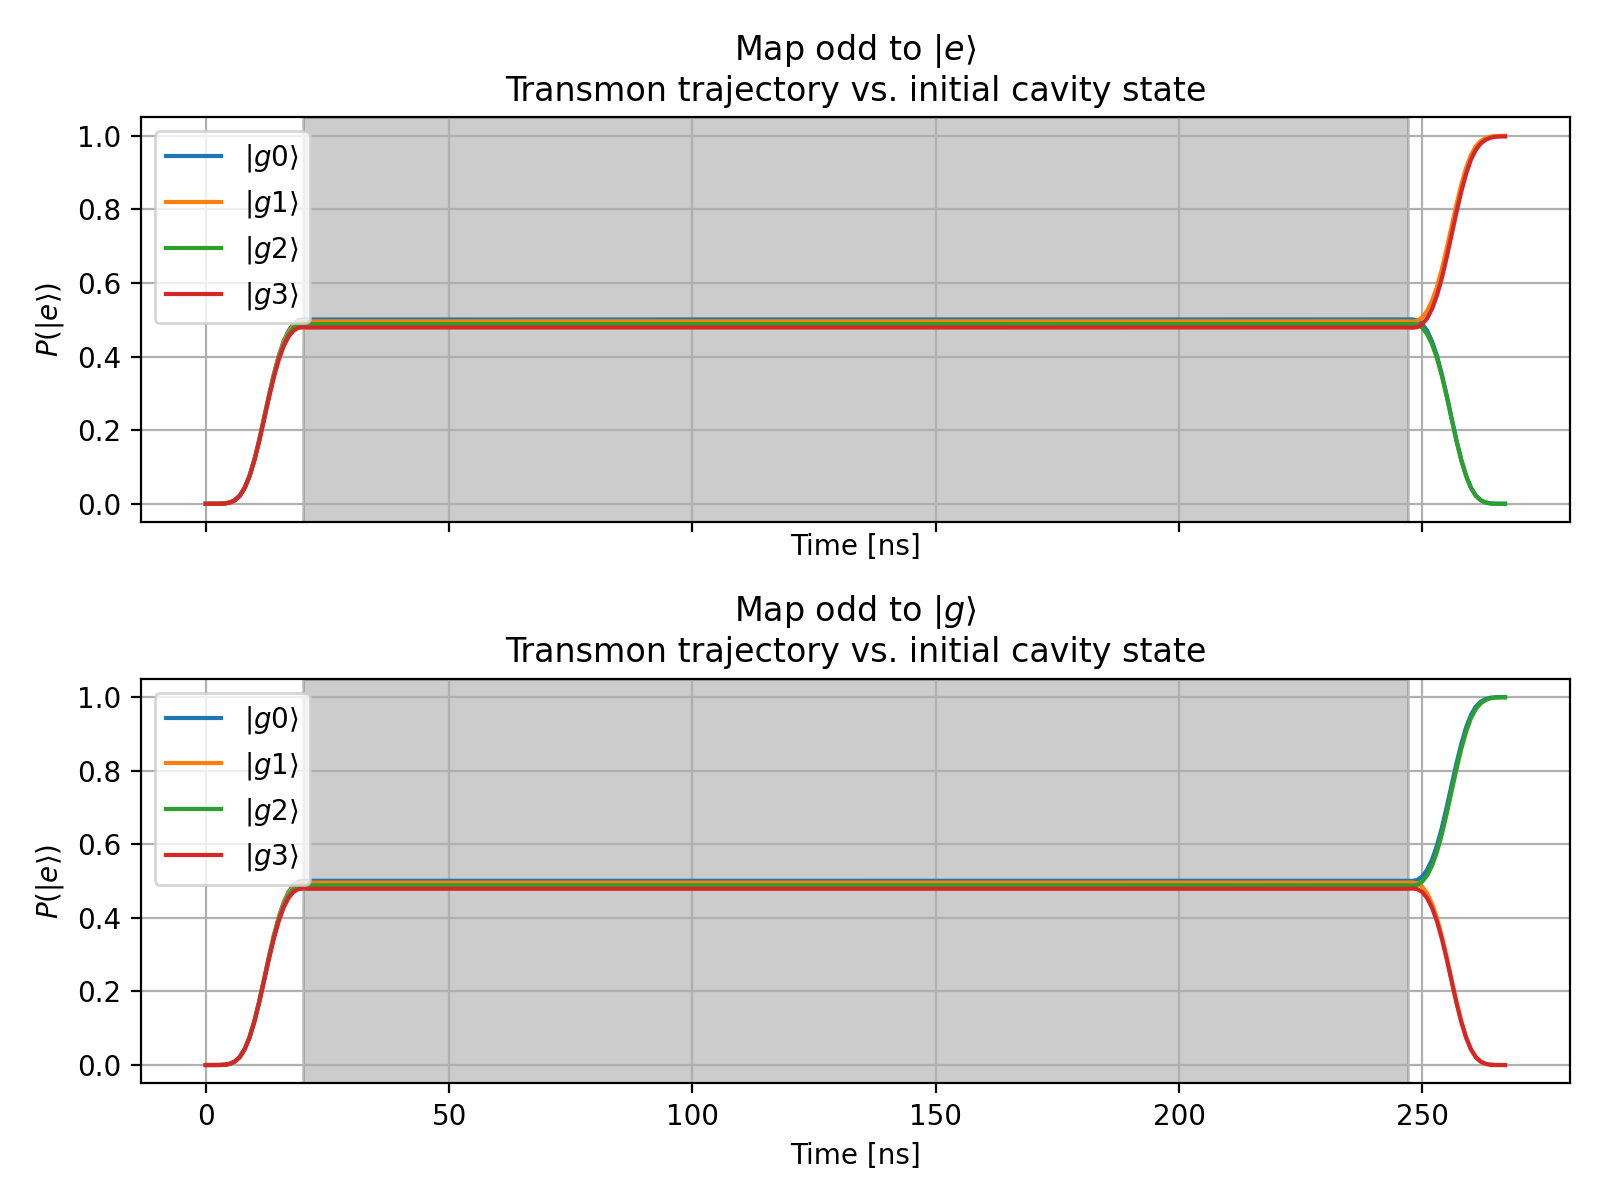

In [41]:
fig, (ax, bx) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,6))
for label, result in odd_to_e_results.items():
    # trace over the cavity
    qubit_states = [state.ptrace(qubit.index) for state in result.states]
    e_pops = qutip.expect(qubit.fock_dm(1, full_space=False), qubit_states)
    ax.plot(result.times, e_pops, label=label)
pulse_len = qubit.gaussian_pulse.sigma * qubit.gaussian_pulse.chop
ax.axvspan(pulse_len, result.times.max()-pulse_len, alpha=0.2, color='k')
ax.grid(True)
ax.legend(loc=0)
ax.set_xlabel('Time [ns]')
ax.set_ylabel(r'$P(|e\rangle)$')
ax.set_title('Map odd to $|e\\rangle$\nTransmon trajectory vs. initial cavity state')

for label, result in odd_to_g_results.items():
    # trace over the cavity
    qubit_states = [state.ptrace(qubit.index) for state in result.states]
    e_pops = qutip.expect(qubit.fock_dm(1, full_space=False), qubit_states)
    bx.plot(result.times, e_pops, label=label)
pulse_len = qubit.gaussian_pulse.sigma * qubit.gaussian_pulse.chop
bx.axvspan(pulse_len, result.times.max()-pulse_len, alpha=0.2, color='k')
bx.grid(True)
bx.legend(loc=0)
bx.set_xlabel('Time [ns]')
bx.set_ylabel(r'$P(|e\rangle)$')
bx.set_title('Map odd to $|g\\rangle$\nTransmon trajectory vs. initial cavity state')
fig.tight_layout()

Note that during the idle time (the $C_\pi$ operation, shaded gray region in the plots above), the qubit and cavity are entangled, so when we trace over the cavity we are throwing away information about the state of the transmon.

In [42]:
from qutip.ipynbtools import version_table
version_table()